# Processing the DISEASES database of disease-gene associations

+ [publication](http://dx.doi.org/10.1016/j.ymeth.2014.11.020)
+ [website](http://diseases.jensenlab.org/Search)

In [1]:
# # Download DISEASES data files
# base_url = 'http://download.jensenlab.org/'
# filenames = [
#     'human_disease_integrated_full.tsv',
#     'human_disease_textmining_full.tsv',
#     'human_disease_knowledge_full.tsv',
#     'human_disease_experiments_full.tsv',
# ]

# for filename in filenames:
#     ! wget --no-verbose --directory-prefix download/ {base_url}/{filename}
#     ! gzip -f download/{filename}

In [2]:
# # Download STRING ensembl protein to entrez gene mapping
# url = 'ftp://string-db.org/STRING/9.1/mapping_files/Entrez_mappings/entrez_gene_id.vs.string.v9.05.28122012.txt'
# ! wget --no-verbose --timestamping --directory-prefix download/ {url}

In [3]:
import gzip

import pandas
import numpy
import matplotlib.pyplot
import seaborn

%matplotlib inline

## Read terminologies

In [4]:
# Read entrez genes
url = 'https://raw.githubusercontent.com/dhimmel/entrez-gene/6e133f9ef8ce51a4c5387e58a6cc97564a66cec8/data/genes-human.tsv'
entrez_df = pandas.read_table(url)    
entrez_df = entrez_df[['GeneID', 'Symbol']].rename(columns={'GeneID': 'entrez_gene_id', 'Symbol': 'gene_symbol'})
entrez_df.head(2)

,entrez_gene_id,gene_symbol
0,1,A1BG
1,2,A2M


## Read mappings

In [5]:
# Read Ensembl protein to Entrez Gene mappings
entrez_map_df = pandas.read_table('download/entrez_gene_id.vs.string.v9.05.28122012.txt')
entrez_map_df.columns = 'entrez_gene_id', 'ensembl_protein_id'
entrez_map_df.ensembl_protein_id = entrez_map_df.ensembl_protein_id.map(lambda x: x.split('.')[1])

In [6]:
# DO Slim nodes to subsumed nodes
url = 'https://raw.githubusercontent.com/dhimmel/disease-ontology/72614ade9f1cc5a5317b8f6836e1e464b31d5587/data/slim-terms-prop.tsv'
doslim_prop_df = pandas.read_table(url)
doslim_prop_df = doslim_prop_df.rename(columns={'subsumed_id': 'doid_id'})
doslim_prop_df = doslim_prop_df[['slim_id', 'slim_name', 'doid_id', 'min_distance']]
doslim_prop_df.head(2)

,slim_id,slim_name,doid_id,min_distance
0,DOID:0050156,idiopathic pulmonary fibrosis,DOID:0050156,0
1,DOID:0050425,restless legs syndrome,DOID:0050425,0


In [8]:
# Create a dataframe of DO terms and their names
do_df = doslim_prop_df[['slim_id', 'slim_name']].drop_duplicates()
do_df.head(2)

,slim_id,slim_name
0,DOID:0050156,idiopathic pulmonary fibrosis
1,DOID:0050425,restless legs syndrome


## Read datasets

In [9]:
# Read integrated dataset
column_names = ['ensembl_protein_id', 'gene_symbol', 'doid_id', 'doid_name', 'score']
integrated_df = pandas.read_table('download/human_disease_integrated_full.tsv.gz', names=column_names)
integrated_df.head(2)

,ensembl_protein_id,gene_symbol,doid_id,doid_name,score
0,5S_rRNA,5S_rRNA,DOID:0050290,Trichosporonosis,2.9
1,5S_rRNA,5S_rRNA,DOID:13382,Megaloblastic anemia,2.6


In [10]:
integrated_df = doslim_prop_df.merge(entrez_map_df.merge(integrated_df))
integrated_df = integrated_df.groupby(['slim_id', 'entrez_gene_id'])['score'].max().reset_index()
integrated_df = do_df.merge(entrez_df.merge(integrated_df))
integrated_df.head(2)

,slim_id,slim_name,entrez_gene_id,gene_symbol,score
0,DOID:0050156,idiopathic pulmonary fibrosis,50,ACO2,0.6
1,DOID:0050156,idiopathic pulmonary fibrosis,59,ACTA2,1.0


In [20]:
integrated_df.to_csv('data/integrated.tsv', sep='\t', index=False)

In [18]:
integrated_df.query("slim_name == 'multiple sclerosis' and score >= 2")

,slim_id,slim_name,entrez_gene_id,gene_symbol,score
40571,DOID:2377,multiple sclerosis,213,ALB,2.0
40592,DOID:2377,multiple sclerosis,361,AQP4,3.0
40602,DOID:2377,multiple sclerosis,627,BDNF,2.1
40603,DOID:2377,multiple sclerosis,629,CFB,3.0
40605,DOID:2377,multiple sclerosis,643,CXCR5,3.0
40606,DOID:2377,multiple sclerosis,677,ZFP36L1,3.0
40609,DOID:2377,multiple sclerosis,717,C2,3.0
40624,DOID:2377,multiple sclerosis,868,CBLB,3.2
40630,DOID:2377,multiple sclerosis,920,CD4,3.1
40632,DOID:2377,multiple sclerosis,923,CD6,3.5


In [12]:
len(integrated_df)

81499

In [17]:
sum(integrated_df.score >= 3)

2441

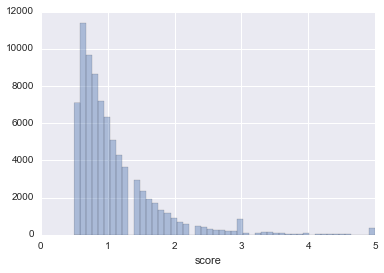

In [14]:
# score distribution
seaborn.distplot(integrated_df.score, kde=False);